<a href="https://colab.research.google.com/github/aasthagoyal46/HousingPricePrediction/blob/master/HousingPrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [0]:
train_url = 'https://raw.githubusercontent.com/aasthagoyal46/HousingPricePrediction/master/house-prices-advanced-regression-techniques/train.csv'
test_url = 'https://raw.githubusercontent.com/aasthagoyal46/HousingPricePrediction/master/house-prices-advanced-regression-techniques/test.csv'

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

In [15]:
train.shape

(1460, 81)

In [14]:

test.shape

(1459, 80)

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [0]:
all_data = pd.concat((train.iloc[:,1:-1],
                      test.iloc[:,1:]))

In [21]:
all_data.shape

(2919, 79)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc0d32ed6a0>,
      dtype=object)

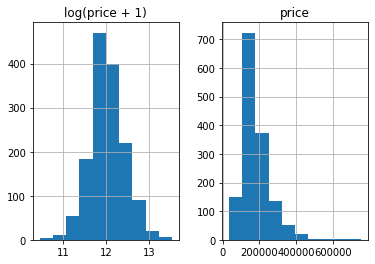

In [23]:
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [0]:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [0]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [0]:
all_data = pd.get_dummies(all_data)

In [30]:
all_data.shape

(2919, 288)

In [0]:
all_data = all_data.fillna(all_data.mean())

In [0]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [0]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [0]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [0]:
model_ridge = Ridge()

In [39]:
rmse_cv(Ridge(alpha = 1)).mean()

0.13136184989399574